# Discount random chain
Gamma = 0.6

In [11]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the different CSVs as DataFrames

In [12]:
in_parent_dir = '/Users/anthony/Playground/tensorboard_logs/10-03/discounted_gamma6'
exp_csv_regex = 'exp*/progress.csv'

exp_csv_pathlist = glob.glob(os.path.join(in_parent_dir, exp_csv_regex))
exp_csv_pathlist

['/Users/anthony/Playground/tensorboard_logs/10-03/discounted_gamma6/exp7_SR_gamma6_sweep/progress.csv',
 '/Users/anthony/Playground/tensorboard_logs/10-03/discounted_gamma6/exp9_STrace_gamma6_sweep/progress.csv']

#### Read all CSVs into a single dataframe

In [13]:
# Read all
exp_df_lists = []
for csv_path in exp_csv_pathlist:
    print('Reading:', csv_path)
    cur_df = pd.read_csv(csv_path, sep='\|\|')
    
    cur_df = cur_df.drop(cur_df.columns[0], axis=1)
    
    exp_df_lists.append(cur_df)

# Concat
data_df = pd.concat(exp_df_lists)

print(len(data_df))
data_df[0:5]

Reading: /Users/anthony/Playground/tensorboard_logs/10-03/discounted_gamma6/exp7_SR_gamma6_sweep/progress.csv
Reading: /Users/anthony/Playground/tensorboard_logs/10-03/discounted_gamma6/exp9_STrace_gamma6_sweep/progress.csv


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


85000


,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
0,10,19,SRAgent,0,0.6,0.0001,1.0,0.05,False,0,30,1.0,0.000125,0.000125,0.000125,0.135144,None,1.161837
1,10,19,SRAgent,0,0.6,0.0001,1.0,0.05,False,1,114,1.0,0.000250,0.000250,0.000250,0.135104,None,1.161765
2,10,19,SRAgent,0,0.6,0.0001,1.0,0.05,False,2,232,1.0,0.000375,0.000375,0.000375,0.135063,None,1.161452
3,10,19,SRAgent,0,0.6,0.0001,1.0,0.05,False,3,22,1.0,0.000500,0.000500,0.000500,0.135023,None,1.161450
4,10,19,SRAgent,0,0.6,0.0001,1.0,0.05,False,4,102,1.0,0.000625,0.000624,0.000625,0.134983,None,1.161390


## Get runs form a specific episode

In [14]:
epis_idx_filter = 9

epis_data_df = data_df[data_df['episode_idx']==epis_idx_filter]

print(len(epis_data_df))
epis_data_df[0:3]

8500


,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
9,10,19,SRAgent,0,0.6,0.0001,1.0,0.05,False,9,38,1.0,0.000999,0.000998,0.000999,0.134864,None,1.159999
19,10,19,SRAgent,2,0.6,0.0001,1.0,0.05,False,9,110,1.0,0.000625,0.000624,0.000625,0.134983,None,1.161403
29,10,19,SRAgent,4,0.6,0.0001,1.0,0.05,False,9,82,0.0,0.000874,0.000874,0.000874,0.134903,None,1.161112


#### Get different sub-DataFrames depending on the run

In [15]:
from itertools import product

indep_cols = ['agentCls_name', 'use_true_s_mat']

# Get all the different combinations of independent cols
indep_col_val_list = []
for indep_col in indep_cols:
    indep_col_val_list.append( list(set(epis_data_df[indep_col].values)) )
indep_col_val_cartesian_prod = product(*indep_col_val_list)

# Filter for sub-dataframes, one for each combination
indep_col_df_dict = {}

for val_tup in indep_col_val_cartesian_prod:    
    # Filter
    cur_df = epis_data_df.copy(deep=True)
    for i in range(len(indep_cols)):
        cur_indep_col = indep_cols[i]
        cur_df = cur_df[cur_df[cur_indep_col] == val_tup[i]]
    
    # Save
    if len(cur_df) > 0:
        cur_comb_name = '_'.join([str(e) for e in list(val_tup)])
        indep_col_df_dict[cur_comb_name] = cur_df
    
# Print
for k in indep_col_df_dict:
    print(k, len(indep_col_df_dict[k]))

STraceAgent_False 7650
SRAgent_False 850


### Plot RMSE

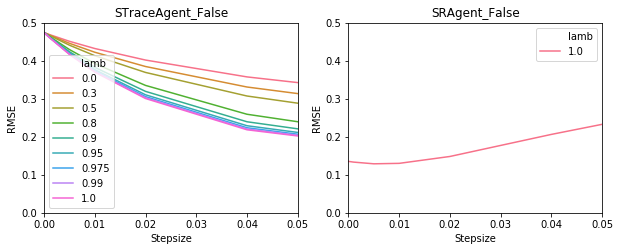

In [20]:
# ==
# Specify plots
plot_x = 'lr'
plot_y = 'v_vec_rmse'
plot_hue = 'lamb'
plot_ci = None  # Estimator, [None, 'sd']


# ==
# Plot

plt.figure(figsize=(10, 3.5))

# Generate subplots
total_n_plots = len(indep_col_df_dict)
n_plot_counter = 1
for k in indep_col_df_dict:
    # Current
    cur_df = indep_col_df_dict[k]
    
    # Generate palette
    n_hues = len(set(cur_df[plot_hue].values))
    c_palette = sns.color_palette("husl", n_hues)
    
    # Plot
    plt.subplot(1, total_n_plots, n_plot_counter)
    sns.lineplot(x=plot_x, y=plot_y, hue=plot_hue, 
                 ci=plot_ci, 
                 palette = c_palette,
                 data=cur_df)
    
    
    plt.ylim([0, 0.5])
    plt.xlim([0, 0.05])
    plt.ylabel('RMSE')
    plt.xlabel('Stepsize')
    plt.title(str(k))
    
    # Counter var
    n_plot_counter += 1
    


### Plot distribution of RMSE

8233


Text(0.5, 1.0, 'Distribution of RMSE under 0.1')

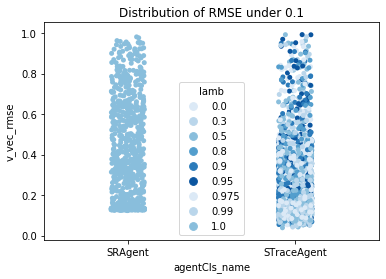

In [19]:
# Filter for dataframe
cur_df = epis_data_df.copy(deep=True)
cur_df = cur_df[cur_df['use_true_s_mat'] == False]
cur_df = cur_df[cur_df['v_vec_rmse'] < 1.0]
print(len(cur_df))

# Generate hue colour palette
c_palette = sns.color_palette("Blues")
#c_palette = sns.color_palette("ch:s=0.0,r=1.2")

# ==
# Plot
sns.stripplot(x='agentCls_name', y='v_vec_rmse', 
              hue='lamb', 
              palette=c_palette,
              data=cur_df)
plt.title('Distribution of RMSE under 0.1')


In [20]:
epis_data_df[epis_data_df['use_true_s_mat'].isin([False])]

,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
9,10,19,LambdaAgent,0,1.0,0.0001,1.0,0.05,False,9,38,1.0,0.505057,0.499800,0.501255,0.273362,None,None
19,10,19,LambdaAgent,2,1.0,0.0001,1.0,0.05,False,9,110,1.0,0.502844,0.499251,0.500683,0.272939,None,None
29,10,19,LambdaAgent,4,1.0,0.0001,1.0,0.05,False,9,82,0.0,0.503688,0.499251,0.501254,0.272725,None,None
39,10,19,LambdaAgent,6,1.0,0.0001,1.0,0.05,False,9,180,1.0,0.502794,0.498853,0.500848,0.272920,None,None
49,10,19,LambdaAgent,8,1.0,0.0001,1.0,0.05,False,9,14,0.0,0.500750,0.498199,0.499487,0.273195,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76459,10,19,SRAgent,90,1.0,1.0000,0.0,0.05,False,9,10,1.0,10.000000,10.000000,10.000000,9.503947,None,6.98824
76469,10,19,SRAgent,92,1.0,1.0000,0.0,0.05,False,9,220,1.0,10.000000,1.000000,9.052632,9.036403,None,7.62054
76479,10,19,SRAgent,94,1.0,1.0000,0.0,0.05,False,9,210,0.0,10.000000,1.000000,9.526316,9.274399,None,8.46688
76489,10,19,SRAgent,96,1.0,1.0000,0.0,0.05,False,9,106,1.0,12.000000,10.000000,10.157895,9.667022,None,7.09227
